In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torchvision.models import vit_b_16
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import timm
import cv2
import numpy as np
import os

import wandb

%run helpFunction.ipynb

/Users/silvanwiedmer/Desktop/VisionTransformer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


\begin{table}
\caption{Test Klassifikations Metriken}
\label{tab:model_performance}
\begin{tabular}{llllr}
\toprule
Modell & Accuracy & Precision & Recall & F1-Score \\
\midrule
InceptionV3 & 83\% & 83\% & 83\% & 83.000000 \\
ViT & 83\% & 83\% & 83\% & 83.000000 \\
Hybridmodel - ViT - DeiT & 82\% & 82\% & 82\% & 82.000000 \\
Hybridmodel - ViT Lite - DeiT & 82\% & 82\% & 82\% & 82.000000 \\
DeiT & 81\% & 81\% & 82\% & 81.000000 \\
ViT Lite & 79\% & 79\% & 79\% & 79.000000 \\
Basic CNN & 78\% & 80\% & 78\% & 78.000000 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/rg/wpq9g3gn2_sg42m9vzpp7flw0000gn/T/ipykernel_11085/1995663629.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Modell').apply(lambda x: x.nlargest(1, 'F1-Score')).reset_index(drop=True)


In [2]:
from data_preprocessing import apply_canny, apply_morphology, black_and_white

In [3]:
wandb.init(project="VisionTransformer")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: silvan-wiedmer (silvan-wiedmer-fhgr). Use `wandb login --relogin` to force relogin


In [4]:
class VerkehrsschilderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, subfolder in enumerate(['y', 'n']):
            folder_path = os.path.join(self.root_dir, subfolder)
            for image_name in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)

        canny_image = apply_canny(image, (224, 224))
        morphology_image = apply_morphology(image, (224, 224))
        bw_image = black_and_white(image, (224, 224))

        combined_image = np.concatenate((canny_image, morphology_image, bw_image), axis=-1)

        combined_image = Image.fromarray(np.uint8(combined_image))
        if self.transform:
            combined_image = self.transform(combined_image)

        return combined_image, label


# transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomGrayscale(p=0.2),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset erstellen
dataset = VerkehrsschilderDataset('../data', transform=transform)

total_count = len(dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.15 * total_count)
test_count = total_count - train_count - valid_count  # Adjust to ensure all data is used

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_count, valid_count, test_count])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
class_names = ['Wartelinie', 'keine Wartelinie']

In [5]:
print(total_count)
VerkehrsschilderDataset.__getitem__(dataset, 900)

1456


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ...,  0.3916,  0.3219, -1.8044],
          [ 0.7576,  0.7751,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


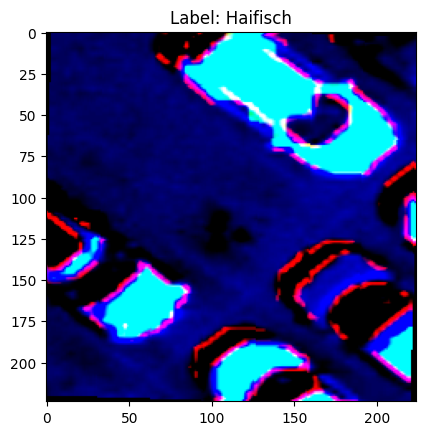

In [6]:
def show_image(image, label):
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title('Label: ' + ('Haifisch' if label == 0 else 'keine Haifisch'))
    plt.show()

show_image(VerkehrsschilderDataset.__getitem__(dataset, 10)[0], VerkehrsschilderDataset.__getitem__(dataset, 10)[1])

In [7]:
class DeiTModel(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(DeiTModel, self).__init__()
        self.deit = timm.create_model('deit_base_patch16_224', pretrained=True)
        self.deit.head = nn.Identity()  # Entfernen des Kopfes
        self.num_features = self.deit.embed_dim  # Typischerweise 768 für 'deit_base_patch16_224'

        # Hinzufügen der neuen Schichten
        self.fc1 = nn.Linear(self.num_features, 768)
        self.bn1 = nn.BatchNorm1d(768)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.deit(x)
        x = x.view(x.size(0), -1)  # Flachdrücken der Features
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
model = DeiTModel()

device = torch.device("cpu")

if torch.cuda.is_available():
    print("Using Cuda Device")
    device = torch.device("cuda")

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.fc2.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [9]:
def validate_model(model, criterion, valid_loader):
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_loss = validation_loss / len(valid_loader)
    validation_accuracy = 100 * correct / total
    
    print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    return validation_loss, validation_accuracy


In [10]:
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=25, patience=5):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
        
        val_loss, val_accuracy = validate_model(model, criterion, valid_loader)

        wandb.log({
            "loss": epoch_loss,
            "accuracy": epoch_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    return history

In [11]:
def evaluate_model(model, criterion, test_loader, class_names):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total

    prediction_csv(all_labels, all_preds, 'DeiT')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - DeiT')
    plt.show()

    wandb.log({"test_loss": test_loss, "test_acc": accuracy})

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch 1/1, Training Loss: 0.5459, Training Accuracy: 71.74%
Validation Loss: 0.4805, Validation Accuracy: 78.90%


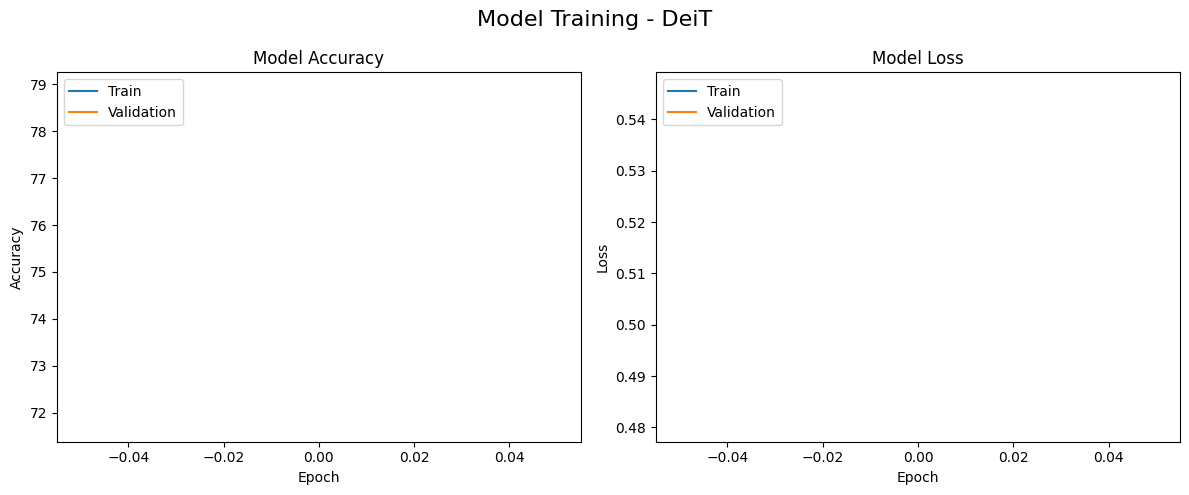

In [14]:
history = train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.suptitle('Model Training - DeiT', fontsize=16)
plt.tight_layout()
plt.show()

              precision    recall  f1-score     support
0              0.891566  0.718447  0.795699  103.000000
1              0.786765  0.922414  0.849206  116.000000
accuracy       0.826484  0.826484  0.826484    0.826484
macro avg      0.839165  0.820430  0.822453  219.000000
weighted avg   0.836055  0.826484  0.824041  219.000000
82.64840182648402
  Modell Accuracy Precision Recall F1-Score                       Date
0   DeiT      83%       84%    82%      82% 2024-11-01 20:02:35.096186


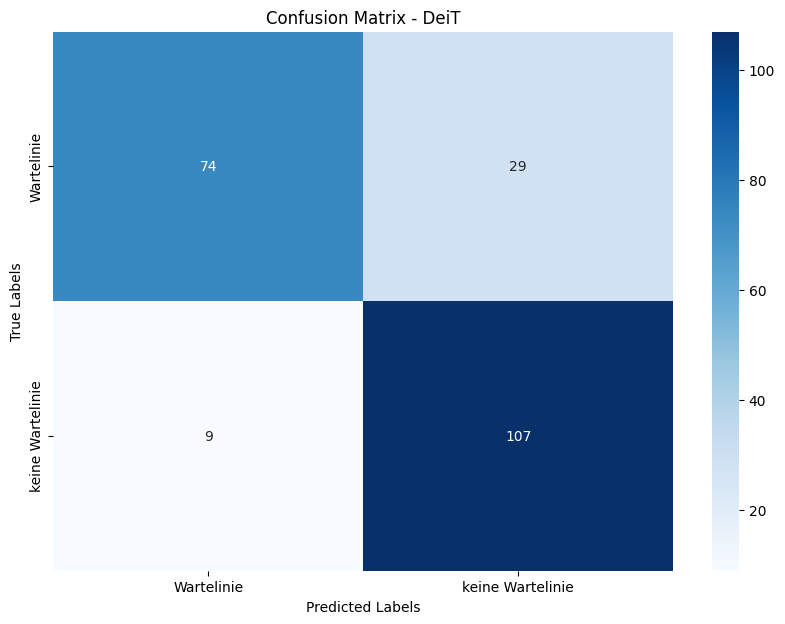

Test Loss: 0.3902, Test Accuracy: 82.65%


In [15]:
evaluate_model(model, criterion, test_loader, class_names)

In [16]:
wandb.finish()

accuracy,▁█
loss,█▁
test_acc,▁
test_loss,▁
val_accuracy,█▁
val_loss,█▁
accuracy,71.737
loss,0.54588
test_acc,82.6484
test_loss,0.39021
val_accuracy,78.89908
